In [17]:
from bitarray import bitarray
import mmh3
import random
import numpy as np
import math
import sklearn.preprocessing

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler 
import pandas as pd


In [20]:
file = pd.read_csv("/Users/aditijain/Desktop/NewFolderWithItems/facebook-v-predicting-check-ins/train.csv")
file.head()



,row_id,x,y,accuracy,time,place_id
0,0,0.7941,9.0809,54,470702,8523065625
1,1,5.9567,4.7968,13,186555,1757726713
2,2,8.3078,7.0407,74,322648,1137537235
3,3,7.3665,2.5165,65,704587,6567393236
4,4,4.0961,1.1307,31,472130,7440663949


In [21]:
for col in file.columns:
    print(col)



row_id
x
y
accuracy
time
place_id


In [22]:

x_train = np.array(file.values[:,1:-1])
print(x_train[0:4])


[[7.94100e-01 9.08090e+00 5.40000e+01 4.70702e+05]
 [5.95670e+00 4.79680e+00 1.30000e+01 1.86555e+05]
 [8.30780e+00 7.04070e+00 7.40000e+01 3.22648e+05]
 [7.36650e+00 2.51650e+00 6.50000e+01 7.04587e+05]]


In [43]:
y_train = np.array(file.values[:,-1])
print(y_train[0:4])


[8.52306562e+09 1.75772671e+09 1.13753724e+09 6.56739324e+09]


In [24]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)

x_train


array([[-1.47174853,  1.4126682 , -0.25140462,  0.23225422],
       [ 0.33487188, -0.07100038, -0.60869758, -0.99688213],
       [ 1.157625  ,  0.70610658, -0.07711537, -0.40818384],
       ...,
       [-0.70005223,  0.47313726, -0.13811661,  1.38745993],
       [-0.32757193,  1.0404437 , -0.11197322,  1.50519267],
       [ 0.85824799, -1.00942309, -0.57383973, -1.35899994]])

In [25]:
f = lambda x: x % 23 
g=lambda x: x%2


In [44]:
y_train=f(y_train)

y_train[0:4]


array([15., 13., 15.,  8.])

In [45]:
y_train=g(y_train)

y_train[0:4]

array([1., 1., 1., 0.])

In [29]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [46]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10, shuffle=True,random_state=7)
modelCV = LogisticRegression()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, x_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.521


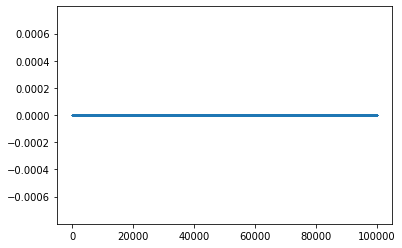

In [31]:
preds =classifier.predict(x_train[0:100000])
plt.scatter(np.arange(len(preds)), preds, s=0.1)

In [32]:
class BloomFilter:
    
    def __init__(self, size, model): #hash count is 1
        self.size = size
      #  self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)
        self.model=model #classifier model associated as hash function
        
    def add(self, num):
        result=math.floor(model.predict(num)[0]*(self.size-1))    
        self.bit_array[result] = 1
            
    def lookup(self, num):
        #for seed in range(1,self.hash_count+1):
            #result = mmh3.hash(str(num), seed) % self.size
        result=math.floor(self.model.predict(num)[0]*(self.size-1))    
        if self.bit_array[result] == 0:
                return False
        return True

    def add_init(self,x_train,y_train):
        pred = self.model.predict(x_train)
        for i in range(len(pred)):
            if(y_train[i]==1):
                result = math.floor(pred[i][0]*(self.size-1))
                self.bit_array[result] = 1
    
    def predict(self,x):
        initpred = self.model.predict(x)
        indexes = []
        for i in range(len(initpred)):
            indexes += [math.floor(initpred[i][0]*(bf.size-1))]
        pred = []
        for i in indexes:
            pred += [self.bit_array[i]]
        return np.array(pred)

#(Input:bloom filter,number array,ratio; Output:(-1) for false negative, otherwise fpr)
def fpr_kraska_hash(bf,x,y):
    pred = bf.predict(x)
    tn, fp, fn, tp = confusion_matrix(y, pred,labels=[False,True]).ravel() 
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k


def fpr_test(x,bf,y):
    pred=bf.predict(x)
    fp=0
    tn=0
    for i in range(len(pred)):
        if((pred[i]==1)and(y[i]==0)):
            fp+=1
        if((pred[i]==0) and (y[i]==0)):
            tn+=1
        if((pred[i]==0) and (y[i]==1)):
            return -1
    print(fp)
    print(tn)
    return fp/(fp+tn)
#(Input:size of bloom filter, total numbers, ratio of numbers inserted; Output: prints inputs and fpr)
def outputs(m,n,r):
    find_fpr(m,model,n,r)
    #print("For m=%d, k=%d, n=%d, r=%.3f: fpr=%.3f"%(m,k,n,r,find_fpr(m,k,n,r)))

In [33]:
m=25

In [34]:
bf=BloomFilter(m,classifier)

In [40]:
y=y_train.reshape(-1,1)

In [41]:
bf.add_init(x_train,y)

IndexError: invalid index to scalar variable.

In [ ]:
print(fpr_kraska_hash(bf,x_train,y_train))